In [1]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import math

In [2]:
train_file = open('sample_train.txt', 'r') 
paths = train_file.readlines();

for i in range(0, len(paths)):
    paths[i] = paths[i].rstrip()

In [18]:
train_paths = []
for i in paths:
    train_paths.append([i.split(' ')[0], i.split(' ')[1]])

X = []
train_data = []
for i in train_paths:
    image = np.array(Image.open(i[0]).convert('L'), dtype='uint8')
    X.append(image)
    image = np.reshape(image, (256*256, 1))
    train_data.append([image, i[1]])
    
##train_data contains list(image_array, lable)  

In [4]:
def read_images(path, sz=None):
    X = []
    for files in glob.glob(path + "/*.jpg"):
        image = np.array(Image.open(files).convert('L'), dtype='uint8')
        X.append(image)
    return X

def normalize(X, low, high):
    X = np.array(X)
    min_X, max_X = np.min(X), np.max(X)
    X = X - float(min_X)
    X = X / float((max_X - min_X))
    X = X * (high - low)
    X = X + low
    return np.array(X)

def asRowMatrix(X):
    if len(X) == 0:
        return np.array([])
    mat = []
    for i in range(0, len(X)):
        mat.append(np.reshape(X[i], (X[0].shape[0] * X[0].shape[0], )))
    return np.array(mat)

def subplot(title, images, rows, cols, subt = "subplot", subts = [], colormap='gray', ticks_visible=True):
    fig = plt.figure(figsize=(10,10))
    # main title
    fig.text(.5, .95, title, horizontalalignment='center') 
    for i in range(len(images)):
        ax0 = fig.add_subplot(rows,cols,(i+1))
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax0.get_yticklabels(), visible=False)
        if len(subts) == len(images):
            plt.title("%s %s" % (subt, str(subts[i])))
        else:
            plt.title("%s %d" % (subt, (i+1)))
        plt.imshow(np.asarray(images[i]), cmap=colormap)
    plt.show()

def pca(X):
    [n,d] = X.shape
    mu = X.mean(axis=0)
    X = X - mu
    if n>d:
        C = np.dot(X.T,X)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
    else:
        C = np.dot(X,X.T)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T,eigenvectors)
        for i in range(n):
            eigenvectors[:,i] = eigenvectors[:,i]/np.linalg.norm(eigenvectors[:,i])
            
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    return [eigenvalues, eigenvectors, mu]

def project(W, X, mu = None):
    if mu is None:
        return np.dot(X,W)
    return np.dot(X - mu, W)

def reconstruct(W, Y, mu=None):
    if mu is None:
        return np.dot(Y,W.T)
    return np.dot(Y, W.T) + mu

def weight_img(image, components):
    numEvs = components
    P = project(eig_vecs[:,0:numEvs], image.reshape(1,-1), mu)
    return P

def reconstruct_img(image):
    steps = [i for i in range(10, min(len(X), 320), 20)]
    E = []
    for i in range(len(steps)):
        numEvs = steps[i]
        P = project(eig_vecs[:,0:numEvs], image.reshape(1,-1), mu)
        R = reconstruct(eig_vecs[:,0:numEvs], P, mu)
        # reshape and append
        R = R.reshape(image.shape)
        E.append(normalize(R,0,255))
    return E, steps

def MSE(X, Y):
    m, n = X.shape
    error = 0
    for i in range(m):
        for j in range(n):
            error += (X[i, j] - Y[i, j])**2
    error /= (m * n)
    return error

In [10]:
train_data[0][0].shape

(65536, 1)

In [22]:
[eig_val, eig_vecs, mu] = pca(asRowMatrix(X))
components = 32

In [23]:
eig_vecs.shape

(65536, 9)

In [24]:
asRowMatrix(X).shape

(9, 65536)

In [25]:
Eig_face = []
for i in range(min(len(X), components)):
    e = eig_vecs[:,i].reshape(X[0].shape)
    Eig_face.append(normalize(e, 0, 255))

In [26]:
train_data_X = []
train_data_Y = []
for i in range(0, len(train_data)):
    train_data_X.append(weight_img(train_data[i][0], components).flatten())
    train_data_Y.append(train_data[i][1])

In [27]:
eig_vecs

array([[-3.21047139e-03,  4.11322407e-03,  4.51513959e-03, ...,
        -6.68365035e-05,  2.59225267e-03, -1.84218271e-03],
       [-2.99875758e-03,  4.24949702e-03,  4.05230176e-03, ...,
         1.00379637e-04,  2.78421916e-03, -1.77113434e-03],
       [-2.67152517e-03,  4.42383710e-03,  3.82022845e-03, ...,
        -2.77005526e-04,  3.53502712e-03, -4.25275238e-03],
       ...,
       [-2.30171897e-03,  1.81946355e-03, -4.88919650e-05, ...,
        -1.14304703e-02, -2.27520493e-03,  1.16024524e-02],
       [-2.34318561e-03,  1.95762254e-03, -1.00713099e-04, ...,
        -1.13114352e-02, -3.03617204e-03,  1.29742569e-02],
       [-2.44104731e-03,  2.02679177e-03, -1.15447092e-04, ...,
        -1.11390549e-02, -3.29200379e-03,  1.41226078e-02]])

In [28]:
Eig_face

[array([[118.06537264, 122.115118  , 128.37454885, ..., 120.440295  ,
         121.33008346, 133.97095297],
        [121.65988674, 122.72128547, 125.35568581, ..., 115.49117001,
         116.54326835, 118.12714754],
        [125.52177695, 122.64189936, 120.37178225, ..., 113.17427702,
         118.03252722, 113.2925718 ],
        ...,
        [  8.80952043,  18.49470856,  26.82675317, ..., 137.44565922,
         132.14977588, 127.5994226 ],
        [  8.63798017,  14.98186462,  22.972456  , ..., 135.09954098,
         132.29792994, 128.4204961 ],
        [  9.92411714,  14.35115011,  19.84722878, ..., 135.44834813,
         134.65515772, 132.7832206 ]]),
 array([[185.27239295, 187.01355756, 189.24110718, ..., 188.03578358,
         190.16397941, 197.93855573],
        [187.47899557, 187.69162503, 187.99816936, ..., 181.85154525,
         186.46164745, 189.30817246],
        [189.12408492, 187.44821804, 186.51471189, ..., 177.77271446,
         184.83415162, 183.72539318],
        ...,


In [29]:
train_data_X = np.array(train_data_X)
train_data_Y = np.array(train_data_Y)

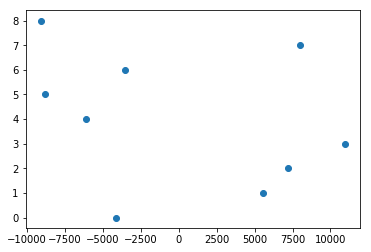

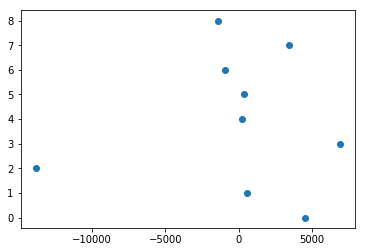

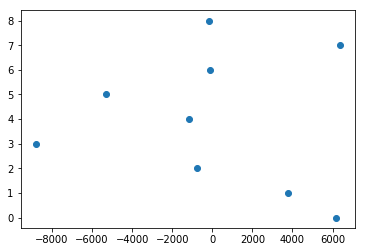

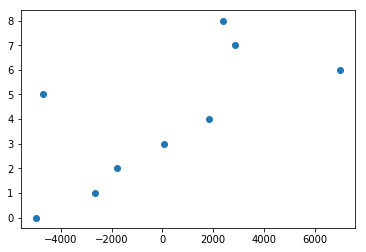

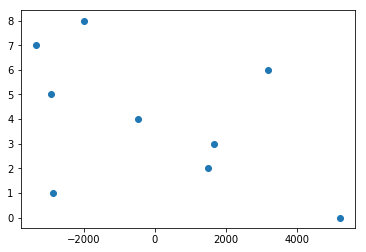

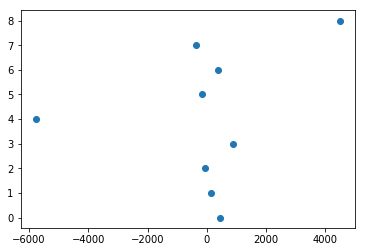

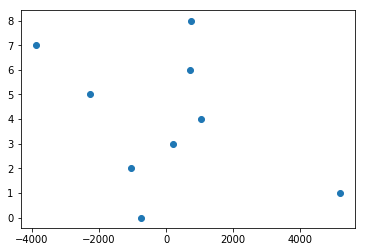

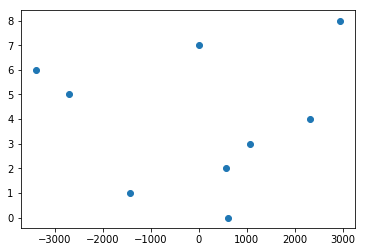

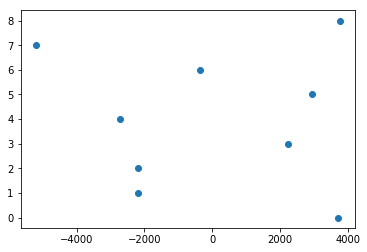

IndexError: index 9 is out of bounds for axis 1 with size 9

In [30]:
for i in range(0, 32):
    plt.scatter(train_data_X[:,i], [i for i in range(0, train_data_X.shape[0])])
    plt.show()

In [31]:
test_file = open('sample_test.txt', 'r') 
paths = test_file.readlines();

for i in range(0, len(paths)):
    paths[i] = paths[i].rstrip()
    
test_data = []

for i in paths:
    image = np.array(Image.open(i).convert('L'), dtype='uint8')
    image = np.reshape(image, (256*256, 1))
    test_data.append(image)

In [32]:
test_data_X = []
for i in range(0, len(test_data)):
    test_data_X.append(weight_img(test_data[i], components).flatten())

In [33]:
test_data_X = np.array(test_data_X)

In [34]:
def separate_By_Class(data_x, data_y):
    separated_dict = {}
    for i in range(len(data_x)):
        key = data_x[i]
        if (data_y[i] not in separated_dict):
            separated_dict[data_y[i]] = []
        separated_dict[data_y[i]].append(key)
    return separated_dict

def mean(numbers):
    num = sum(numbers)
    deno = float(len(numbers))
    return num/deno

def stdev(numbers):
    avg = mean(numbers)
    var_num = sum([pow(x-avg,2) for x in numbers])
    var_deno = float(len(numbers)-1)
    variance = var_num / var_deno
    return math.sqrt(variance)

def get_distribution(data_x, data_y):
    distribution = [(mean(attribute), stdev(attribute)) for attribute in zip(*data_x)]
    return distribution

def distribution_by_class(data_x, data_y):
    separated = separate_By_Class(data_x, data_y)
    distributions = {}
    for classes, keys in separated.items():
        distributions[classes] = get_distribution(keys, data_y)
    return distributions

In [35]:
def calculate_Probability(x, mean, stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    return math.log((1 / (math.sqrt(2*math.pi) * stdev)) * exponent)

def calculate_Class_Probabilities(distributions, X):
    probabilities = {}
    for Value, dist in distributions.items():
        probabilities[Value] = 1
        for i in range(len(dist)):
            mean, stdev = dist[i]
            x = X[i]
            probabilities[Value] += calculate_Probability(x, mean, stdev)
    return probabilities

In [36]:
def predict(distributions, X):
    probabilities = calculate_Class_Probabilities(distributions, X)
    bestLabel, bestProb = None, -100
    for label, probability in probabilities.items():
        if probability > bestProb or bestLabel is None:
            bestProb = probability
            bestLabel = label
    return bestLabel

def get_Predictions(distributions, testSet):
    predictions = []
    for i in range(len(testSet)):
        result = predict(distributions, testSet[i])
        predictions.append(result)
    return predictions

def getAccuracy(lable, predictions):
    correct = 0
    for x in range(len(lable)):
        if lable[x] == predictions[x]:
            correct += 1
    return (correct/float(len(lable))) * 100.0

In [37]:
def classifier(X_train, Y_train, X_test):
    summary = distribution_by_class(X_train, Y_train)
    prediction = get_Predictions(summary, X_test)
#     accuracy = getAccuracy(Y_test, prediction)
    return prediction

In [38]:
train_data_X[0]

array([-4141.2689524 ,  4539.211164  ,  6153.06632592, -4984.44353015,
        5223.07995245,   458.54989975,  -734.98528833,   607.68897299,
        3713.95311629])

In [39]:
p = classifier(train_data_X, train_data_Y, test_data_X)

In [40]:
p

['abc', 'abc', 'alice', 'bob', 'bob']